# REINFORCE in PyTorch

Just like we did before for Q-learning, this time we'll design a PyTorch network to learn `CartPole-v1` via policy gradient (REINFORCE).

Most of the code in this notebook is taken from approximate Q-learning, so you'll find it more or less familiar and even simpler.

In [ ]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [ ]:
!pip install gymnasium
!pip install gymnasium[classic_control]

In [9]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

A caveat: with some versions of `pyglet`, the following cell may crash with `NameError: name 'base' is not defined`. The corresponding bug report is [here](https://github.com/pyglet/pyglet/issues/134). If you see this error, try restarting the kernel.

In [24]:
from gymnasium.spaces import Box

In [26]:
Box(low=-1.0, high=2.0, shape=(3, 4), dtype=np.float32).shape

(3, 4)

In [23]:
env.observation_space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

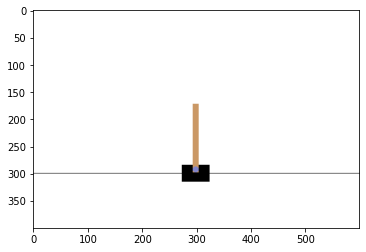

In [10]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

# gym compatibility: unwrap TimeLimit
if hasattr(env, '_max_episode_steps'):
    env = env.env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render())

In [11]:
state_dim, n_actions

((4,), 2)

# Building the network for REINFORCE

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states.

For numerical stability, please __do not include the softmax layer into your network architecture__.
We'll use softmax or log-softmax where appropriate.

In [12]:
import torch
import torch.nn as nn

In [13]:
state_dim

(4,)

In [14]:
# Build a simple neural network that predicts policy logits. 
# Keep it simple: CartPole isn't worth deep architectures.
def create_model(obs_dim, n_actions, hidden_size=16):
    model = nn.Sequential(
        nn.Linear(np.prod(obs_dim), hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, n_actions)
    )
    return model

model = create_model(state_dim, n_actions)
print(model)

Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=2, bias=True)
)


#### Predict function

Note: output value of this function is not a torch tensor, it's a numpy array.
So, here gradient calculation is not needed.
<br>
Use [no_grad](https://pytorch.org/docs/stable/autograd.html#torch.autograd.no_grad)
to suppress gradient calculation.
<br>
Also, `.detach()` (or legacy `.data` property) can be used instead, but there is a difference:
<br>
With `.detach()` computational graph is built but then disconnected from a particular tensor,
so `.detach()` should be used if that graph is needed for backprop via some other (not detached) tensor;
<br>
In contrast, no graph is built by any operation in `no_grad()` context, thus it's preferable here.

In [19]:
import torch.nn.functional as F

In [20]:
@torch.no_grad()
def predict_probs(model, states):
    """ 
    Predict action probabilities given states.
    :param model: nn.Module
    :param states: numpy array of shape [batch, state_shape]
    :returns: numpy array of shape [batch, n_actions]
    """
    # convert states, compute logits, use softmax to get probability
    states_tensor = torch.as_tensor(states, dtype=torch.float32)
    logits = model(states_tensor)
    probs = F.softmax(logits)
    return probs.numpy()

In [21]:
test_states = np.array([env.reset()[0] for _ in range(5)])
test_probas = predict_probs(model, test_states)
assert isinstance(test_probas, np.ndarray), \
    "you must return np array and not %s" % type(test_probas)
assert tuple(test_probas.shape) == (test_states.shape[0], env.action_space.n), \
    "wrong output shape: %s" % np.shape(test_probas)
assert np.allclose(np.sum(test_probas, axis=1), 1), "probabilities do not sum to 1"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


### Play the game

We can now use our newly built agent to play the game.

In [32]:
def generate_session(env, model, t_max=1000):
    """ 
    Play a full session with REINFORCE agent.
    Returns sequences of states, actions, and rewards.
    """
    # arrays to record session
    available_actions = np.arange(env.action_space.n)
    states, actions, rewards = [], [], []
    s, _ = env.reset()

    for t in range(t_max):
        # action probabilities array aka pi(a|s)
        action_probs = predict_probs(model, [s])[0]

        # Sample action with given probabilities.
        a = int(np.random.choice(a=available_actions, p=action_probs, size=1))
        new_s, r, done, _, _ = env.step(a)

        # record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = new_s
        if done:
            break

    return states, actions, rewards

In [33]:
# test it
states, actions, rewards = generate_session(env, model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


In [34]:
print(actions)
print(rewards)

[1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


### Computing cumulative rewards

$$
\begin{align*}
G_t &= r_t + \gamma r_{t + 1} + \gamma^2 r_{t + 2} + \ldots \\
&= \sum_{i = t}^T \gamma^{i - t} r_i \\
&= r_t + \gamma * G_{t + 1}
\end{align*}
$$

In [42]:
def get_cumulative_rewards(rewards,  # rewards at each step
                           gamma=0.99  # discount for reward
                           ):
    """
    Take a list of immediate rewards r(s,a) for the whole session 
    and compute cumulative returns (a.k.a. G(s,a) in Sutton '16).
    
    G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...

    A simple way to compute cumulative rewards is to iterate from the last
    to the first timestep and compute G_t = r_t + gamma*G_{t+1} recurrently

    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    cumulative_rewards = np.zeros_like(rewards, dtype=np.float32)
    curr_g = 0
    for i in range(1, len(rewards) + 1):
      curr_g = rewards[-i] + gamma * curr_g
      cumulative_rewards[-i] = curr_g
        
    return cumulative_rewards

In [45]:
get_cumulative_rewards(rewards)
assert len(get_cumulative_rewards(list(range(100)))) == 100
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9),
    [1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, -2, 3, -4, 0], gamma=0.5),
    [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 2, 3, 4, 0], gamma=0),
    [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


#### Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum_{s_i,a_i} G(s_i,a_i) $$

REINFORCE defines a way to compute the gradient of the expected reward with respect to policy parameters. The formula is as follows:

$$ \nabla_\theta \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \nabla_\theta \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

We can abuse PyTorch's capabilities for automatic differentiation by defining our objective function as follows:

$$ \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

When you compute the gradient of that function with respect to network weights $\theta$, it will become exactly the policy gradient.

In [47]:
# def to_one_hot(y_tensor, ndims):
#     """ helper: take an integer vector and convert it to 1-hot matrix. """
#     y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
#     y_one_hot = torch.zeros(
#         y_tensor.size()[0], ndims).scatter_(1, y_tensor, 1)
#     return y_one_hot

import torch.nn.functional as F

to_one_hot = F.one_hot

In [48]:
def train_on_session(states, actions, rewards, optimizer, 
                     gamma=0.99, entropy_coef=2e-2):
    """
    Takes a sequence of states, actions and rewards produced by generate_session.
    Updates agent's weights by following the policy gradient above.
    Please use Adam optimizer with default parameters.
    """

    # cast everything into torch tensors
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int64)
    cumulative_returns = np.array(get_cumulative_rewards(rewards, gamma))
    cumulative_returns = torch.tensor(cumulative_returns, dtype=torch.float32)

    # predict logits, probas and log-probas using an agent.
    logits = model(states)
    probs = nn.functional.softmax(logits, -1)
    log_probs = nn.functional.log_softmax(logits, -1)

    assert all(isinstance(v, torch.Tensor) for v in [logits, probs, log_probs]), \
        "please compute using torch tensors and don't use predict_probs function"

    # select log-probabilities for chosen actions, log pi(a_i|s_i)
    log_probs_for_actions = torch.sum(
        log_probs * to_one_hot(actions, env.action_space.n), dim=1)
   
    # Compute loss here. Don't forgen entropy regularization with `entropy_coef` 
    policy_loss = -torch.mean(log_probs_for_actions * cumulative_returns)
    entropy = -torch.mean(probs * log_probs)
    
    total_loss = policy_loss - entropy_coef * entropy

    # Gradient descent step
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # technical: return session rewards to print them later
    return np.sum(rewards)

In [49]:
from IPython.display import clear_output

### The actual training

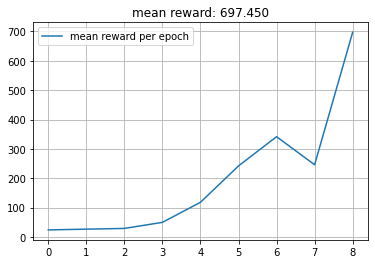

You Win!


In [50]:
mean_session_rewards = []
model = create_model(state_dim, n_actions)
optimizer = torch.optim.Adam(model.parameters(), 5e-3)

for i in range(100):
    rewards = [train_on_session(*generate_session(env, model), 
                                optimizer) for _ in range(100)]  # generate new sessions

    mean_session_rewards.append(np.mean(rewards))
    
    clear_output(True)
    plt.title(f"mean reward: {mean_session_rewards[-1]:.3f}")
    plt.plot(mean_session_rewards, label=f"mean reward per epoch")
    plt.grid()
    plt.legend()
    plt.show()
    
    if mean_session_rewards[-1] > 500:
        print("You Win!")  # but you can train even further
        break

### Results & video

In [51]:
!pip install moviepy
!pip install imageio_ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.9 MB 1.6 MB/s 


In [52]:
# Record sessions

from gymnasium.wrappers import RecordVideo

with RecordVideo(gym.make("CartPole-v1", render_mode="rgb_array"), 
                 video_folder="videos") as env_monitor:
    sessions = [generate_session(env_monitor, model) for _ in range(100)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


[MoviePy] >>>> Building video /content/videos/rl-video-episode-0.mp4
[MoviePy] Writing video /content/videos/rl-video-episode-0.mp4


100%|██████████| 501/501 [00:03<00:00, 146.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/videos/rl-video-episode-0.mp4 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


[MoviePy] >>>> Building video /content/videos/rl-video-episode-1.mp4
[MoviePy] Writing video /content/videos/rl-video-episode-1.mp4


100%|██████████| 501/501 [00:05<00:00, 98.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/videos/rl-video-episode-1.mp4 

[MoviePy] >>>> Building video /content/videos/rl-video-episode-8.mp4
[MoviePy] Writing video /content/videos/rl-video-episode-8.mp4


100%|██████████| 502/502 [00:02<00:00, 213.01it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/videos/rl-video-episode-8.mp4 



[MoviePy] >>>> Building video /content/videos/rl-video-episode-27.mp4
[MoviePy] Writing video /content/videos/rl-video-episode-27.mp4


100%|██████████| 502/502 [00:03<00:00, 164.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/videos/rl-video-episode-27.mp4 

[MoviePy] >>>> Building video /content/videos/rl-video-episode-64.mp4
[MoviePy] Writing video /content/videos/rl-video-episode-64.mp4


100%|██████████| 502/502 [00:02<00:00, 218.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/videos/rl-video-episode-64.mp4 



In [53]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))